In [1]:
import os
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix


c:\Users\Begad\anaconda3\envs\tf27\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\Begad\anaconda3\envs\tf27\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.7.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you w

In [ ]:
#Download Dataset from KaggleHub

path = kagglehub.dataset_download("asdasdasasdas/garbage-classification")
dataset_path = os.path.join(path, "Garbage classification", "Garbage classification")


In [ ]:
#Load and Preprocess Images

img_size = (256, 256)
X, y, text_descriptions = [], [], []
classes = sorted(os.listdir(dataset_path))
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}

def center_crop(img_array, target_size=(224, 224)):
    crop = tf.image.central_crop(img_array, central_fraction=224/256)
    return tf.image.resize(crop, target_size)

for cls in classes:
    class_dir = os.path.join(dataset_path, cls)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        try:
            img = load_img(img_path, target_size=img_size)
            img_array = img_to_array(img)
            img_array = center_crop(img_array)
            img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
            X.append(img_array)
            y.append(class_to_idx[cls])

            # Augment text descriptions
            if cls == "trash":
                desc = np.random.choice([
                    "dirty waste item", "non-recyclable garbage", "mixed trash material"
                ])
            elif cls == "plastic":
                desc = np.random.choice([
                    "plastic bottle", "PET container", "transparent plastic waste"
                ])
            else:
                desc = cls.replace("_", " ")
            text_descriptions.append(desc)
        except Exception as e:
            print(f"Error loading {img_path}: {e}")

X = np.array(X)
y = np.array(y)
y_encoded = to_categorical(y, num_classes=len(classes))
text_descriptions = np.array(text_descriptions)


In [ ]:
#Train-Test Split

X_train, X_val, y_train, y_val, text_train, text_val = train_test_split(
    X, y_encoded, text_descriptions, test_size=0.2, stratify=y, random_state=42
)


In [ ]:
#Compute Class Weights

y_labels = np.argmax(y_train, axis=1)
class_weights = compute_class_weight('balanced', classes=np.unique(y_labels), y=y_labels)
class_weights_dict = dict(enumerate(class_weights))


In [ ]:
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, TextVectorization

#Build Multimodal Fusion Model


# Image input
image_input = Input(shape=(224, 224, 3), name="image_input")
resnet = ResNet50(weights='imagenet', include_top=False, input_tensor=image_input)
for layer in resnet.layers[:-30]:
    layer.trainable = False
resnet_feat = GlobalAveragePooling2D()(resnet.output)

# Text input using tokenized sequence
text_input = Input(shape=(1,), dtype=tf.string, name="text_input")

# Text vectorization
vectorizer = TextVectorization(max_tokens=1000, output_sequence_length=10)
vectorizer.adapt([cls.replace("_", " ") for cls in classes])  # Fit on class names

x_text = vectorizer(text_input)  # Tokenized sequence
x_text = Embedding(input_dim=1000, output_dim=64)(x_text)  # Learnable embeddings
text_feat = GlobalAveragePooling1D()(x_text)  # Aggregate sequence

# Fusion
fused = Concatenate()([resnet_feat, text_feat])
output = Dense(len(classes), activation='softmax')(fused)

# Compile model
model = Model(inputs=[image_input, text_input], outputs=output)
model.compile(optimizer=Adam(1e-4), loss=tfa.losses.SigmoidFocalCrossEntropy(), metrics=['accuracy'])

In [ ]:
# Train Model
history = model.fit(
    {"image_input": X_train, "text_input": text_train},
    y_train,
    validation_data=({"image_input": X_val, "text_input": text_val}, y_val),
    epochs=20,
    batch_size=32,
    class_weight=class_weights_dict
)


Epoch 1/20
64/64 [==============================] - 20s 157ms/step - loss: 0.1631 - accuracy: 0.7199 - val_loss: 0.1730 - val_accuracy: 0.8340
Epoch 2/20
64/64 [==============================] - 8s 124ms/step - loss: 0.0221 - accuracy: 0.9664 - val_loss: 0.1192 - val_accuracy: 0.8577
Epoch 3/20
64/64 [==============================] - 8s 124ms/step - loss: 0.0052 - accuracy: 0.9941 - val_loss: 0.0725 - val_accuracy: 0.8874
Epoch 4/20
64/64 [==============================] - 8s 124ms/step - loss: 0.0029 - accuracy: 0.9980 - val_loss: 0.0720 - val_accuracy: 0.9012
Epoch 5/20
64/64 [==============================] - 8s 124ms/step - loss: 0.0016 - accuracy: 0.9985 - val_loss: 0.0668 - val_accuracy: 0.9091
Epoch 6/20
64/64 [==============================] - 8s 124ms/step - loss: 0.0013 - accuracy: 0.9985 - val_loss: 0.0688 - val_accuracy: 0.9091
Epoch 7/20
64/64 [==============================] - 8s 124ms/step - loss: 7.1390e-04 - accuracy: 0.9990 - val_loss: 0.0687 - val_accuracy: 0.9150
E

16/16 [==============================] - 1s 78ms/step - loss: 0.0810 - accuracy: 0.9170

✅ Validation Accuracy: 0.9170
              precision    recall  f1-score   support

   cardboard       0.96      0.95      0.96        81
       glass       0.90      0.91      0.91       100
       metal       0.85      0.95      0.90        82
       paper       0.94      0.97      0.95       119
     plastic       0.94      0.86      0.90        97
       trash       0.87      0.74      0.80        27

    accuracy                           0.92       506
   macro avg       0.91      0.90      0.90       506
weighted avg       0.92      0.92      0.92       506



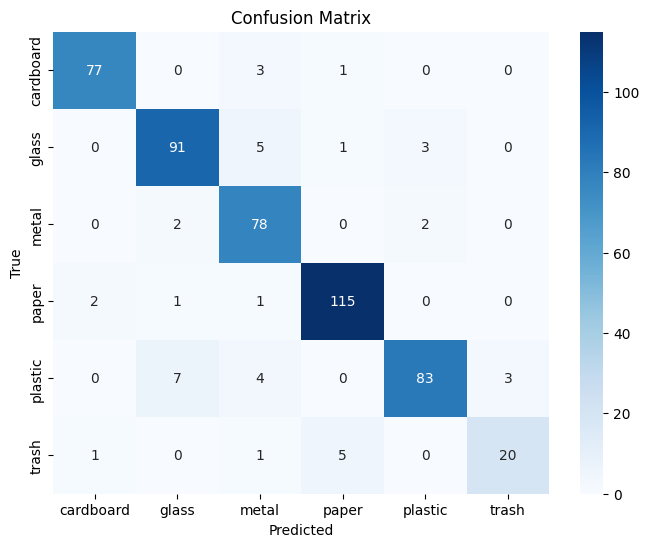

In [ ]:
#Evaluate Model

loss, acc = model.evaluate({"image_input": X_val, "text_input": text_val}, y_val)
print(f"Validation Accuracy: {acc:.4f}")

y_pred = model.predict({"image_input": X_val, "text_input": text_val})
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

print(classification_report(y_true_classes, y_pred_classes, target_names=classes))

# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
# # Save in TensorFlow format
# model.save("multimodal_resnet_text", save_format="tf")
# # print("Multimodal model saved in TensorFlow format.")


INFO:tensorflow:Assets written to: multimodal_resnet_text\assets
✅ Multimodal model saved in TensorFlow format.


c:\Users\Begad\anaconda3\envs\tf27\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
c:\Users\Begad\anaconda3\envs\tf27\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
